# Paper figs

In [1]:
# my own functions
from preprocessing import combine_patient_data, ts_data_to_grids, load_and_process_grid, trim_nan_rows
from prob_models import run_prob
from evaluation import process_single_file
from utils import MetricExplorer, make_explorer, sety, setx # init -> make_explorer

# file handling
from glob import glob
import pandas as pd
import tqdm
import os
from pathlib import Path

# stats and ML
import numpy as np
from scipy.stats import linregress
from sklearn.metrics import (
    precision_recall_curve,
    average_precision_score,
    f1_score,
    precision_score,
    mean_absolute_error,
    #mean_squared_error
)

from sklearn.metrics import root_mean_squared_error

# plotting
from matplotlib import pyplot as plt
from matplotlib.ticker import FixedLocator, MaxNLocator
import seaborn as sns
import datetime

import matplotlib as mpl
mpl.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Nimbus Sans'],
    'font.size': 9,
    'axes.titlesize': 9,
    'axes.labelsize': 9,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'legend.title_fontsize': 9,
    'lines.markersize': 4,
})

model_name_map = dict(zip(['rls', 'arima', 'lstm', '1h lagged', 'mean'],['RLS','SARIMA','LSTM','Persistence','Constant']))

def add_lab(ax, panel_label='A',x=-0.1,y=1.05):
    ax.text(x,y, f'({panel_label})', transform=ax.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')

# Model comparison with RMSE

- [x] more runs:
    - [x] 1h: i5_pctrl_w60_lstm missing -> check logs (12h model processed only 12 patients.. while LSTM Validation ran through).
        - cat /sc/arion/projects/Clinical_Times_Series/cpp_data/runs/20251222_1325/logs/cpp_best.219894342.6.out
    - [x] 15min: i0_pvalidation_w15_arima missing -> Time out after 12h (100/140 subjects). Go for 
        -  cat /sc/arion/projects/Clinical_Times_Series/cpp_data/runs/20251222_1952/logs/cpp_best.219906603.1.out
- minor:
    - [x] one model per class -> Remove LSTM or GRU in Fig 2 based on sweeps
    - [x] Update plot -> scatter plot for Fig 2a
    - [x] Understand patient filtering: in runs valid_days > 20
    - [x] Uniform naming conventions -> Update process chart in biomarker
- major:
    - [x] Make figures for Controls for {Fig 2, Fig 3, Fig 4, Fig 4-Supps} -> [x] make a function!
    - [x] Supps: Add 1h bouts prevented section -> run analysis on {20251222_1325}
    - [x] Supps: Add additional metrics for 15min bouts prevented {20251222_1952}
    - [x] Add fig? Fig 3b: bursts vs error (??)
- Supp figures Results:
    - [50%] Supplementary Fig. RLS Sweeps, SARIMA sweeps
    - [x] Supps Fig 2 on controls
    - [x] Supps Fig 3 on controls and other models
    - [x] Supps Fig 4 15min all metrics (e.g. F1 max)
- Supps figures Methods:
    - Supplementary Figure X 2D matrix and Missing Values
    - Supps Fig Temporal Receptive Fields
    - Supplementary Methods: all hyperpars-sweeps

In [2]:
!ls /sc/arion/projects/Clinical_Times_Series/cpp_data/runs/20251222_1325/predictions/

failed.csv
i0_pvalidation_w60_a_a_marima_h60_burn10.csv
i1_pctrl_w60_a_a_marima_h60_burn10.csv
i2_pvalidation_w60_a_a_mrls_h60_fcross_d0_poly0_logit0_burn10.csv
i3_pctrl_w60_a_a_mrls_h60_fcross_d0_poly0_logit0_burn10.csv
i4_pvalidation_w60_a_a_mlstm_h60_burn10.csv
i5_pctrl_w60_a_a_mlstm_h60_burn10.csv
i6_pvalidation_w60_a_a_mgru_h60_burn10.csv
i7_pctrl_w60_a_a_mgru_h60_burn10.csv
i8_pvalidation_w60_a_a_mlstm_h60_burn10.csv
i9_pctrl_w60_a_a_mlstm_h60_burn10.csv


In [3]:
#configs = pd.read_csv('/sc/arion/projects/Clinical_Times_Series/cpp_data/runs/20251222_1325/best_configs.csv')
#preds = pd.read_csv('/sc/arion/projects/Clinical_Times_Series/cpp_data/runs/20251222_1325/predictions/.csv')

In [4]:
!ls /sc/arion/projects/Clinical_Times_Series/cpp_data/runs/20251222_1952/predictions/

failed.csv
i0_pvalidation_w15_a_a_marima_h60_burn10.csv
i1_pctrl_w15_a_a_marima_h60_burn10.csv
i2_pvalidation_w15_a_a_mrls_h60_fcross_d0_poly0_logit0_burn10.csv
i3_pctrl_w15_a_a_mrls_h60_fcross_d0_poly0_logit0_burn10.csv
i4_pvalidation_w15_a_a_mlstm_h60_burn10.csv
i5_pctrl_w15_a_a_mlstm_h60_burn10.csv
i6_pvalidation_w15_a_a_mgru_h60_burn10.csv
i7_pctrl_w15_a_a_mgru_h60_burn10.csv


#### Load: 1325:60min, 1952:15min

In [35]:
run_path = '/sc/arion/projects/Clinical_Times_Series/cpp_data/runs/20251222_1325/'
#df = pd.read_csv(f'{run_path}/predictions/i2_pvalidation_w60_a_a_mrls_h60_fcross_d0_poly0_logit0_burn10.csv')
#df[['kernel_day', 'n_kernel_recent', 'kernel_hour']].head()
#df = pd.read_csv(f'{run_path}/predictions/i0_pvalidation_w60_a_a_marima_h60_burn10.csv')
#df[['p','d','q','P','D','Q','m']].head()
#df[['p','d','q','P','D','Q','m']].head()
run_path_lstm = '/sc/arion/projects/Clinical_Times_Series/cpp_data/runs/20260116_1303/'        
df = pd.read_csv(f'{run_path_lstm}/predictions/i0_pvalidation_w60_a_a_mlstm_h60_burn10.csv')
df[['a_hidden_size', 'a_num_layers', 'a_learning_rate','a_seq_length', 'a_n_epochs', 'a_batch_size', 'a_dropout']].iloc[0]

a_hidden_size      128.000
a_num_layers         2.000
a_learning_rate      0.001
a_seq_length        20.000
a_n_epochs          50.000
a_batch_size        32.000
a_dropout            0.100
Name: 0, dtype: float64

#### Function defs

###### Load for parameters

In [40]:
#def load_pars():
        
run_path = '/sc/arion/projects/Clinical_Times_Series/cpp_data/runs/20251222_1325/'
run_path_lstm = '/sc/arion/projects/Clinical_Times_Series/cpp_data/runs/20260116_1303/'        

files = [
    f'{run_path}/predictions/i2_pvalidation_w60_a_a_mrls_h60_fcross_d0_poly0_logit0_burn10.csv',
    f'{run_path}/predictions/i0_pvalidation_w60_a_a_marima_h60_burn10.csv',
    f'{run_path_lstm}/predictions/i0_pvalidation_w60_a_a_mlstm_h60_burn10.csv',
    ]

res = []
    
for file in files:
    df = pd.read_csv(file)
    print(df.model_name.unique())
    print(df.n_pars_activity.unique())
    

['rls']
[73]
['arima']
[4.]
['lstm']
[199297]


In [41]:
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Generate some dummy data
np.random.seed(42)
n = 100
data = np.cumsum(np.random.randn(n)) + 10

# Initialize SARIMA with your parameters
# p=1, q=0, d=0, P=1, Q=1, D=0, m=24
model = SARIMAX(data, order=(1, 0, 0), seasonal_order=(1, 0, 1, 24))

# Fit the model
results = model.fit(disp=False)

print("=" * 70)
print("SARIMA Model Internal Structure")
print("=" * 70)

print("\n1. MODEL PARAMETERS (what you specified):")
print(f"   Order (p, d, q): {model.order}")
print(f"   Seasonal order (P, D, Q, m): {model.seasonal_order}")

print("\n2. ESTIMATED PARAMETERS:")
print(f"   Number of parameters: {len(results.params)}")
print(f"   Parameter names: {list(results.params.index)}")
print(f"   Parameter values:")
for name, val in results.params.items():
    print(f"      {name}: {val:.6f}")

print("\n3. STATE SPACE DIMENSIONS:")
print(f"   k_states: {model.k_states} (dimension of state vector)")
print(f"   k_posdef: {model.k_posdef} (dimension of state innovation)")
print(f"   k_endog: {model.k_endog} (number of observed variables)")
print(f"   k_exog: {model.k_exog if hasattr(model, 'k_exog') else 0} (number of exogenous variables)")

print("\n4. STATE VECTOR:")
print(f"   Filtered states shape: {results.filtered_state.shape}")
print(f"   (rows=state dimension, cols=time points)")
print(f"   First few filtered states at time t=50:")
print(f"   {results.filtered_state[:, 50]}")

print("\n5. STATE COVARIANCE:")
print(f"   Filtered state cov shape: {results.filtered_state_cov.shape}")
print(f"   State covariance at time t=50:")
print(results.filtered_state_cov[:, :, 50])

print("\n6. TRANSITION MATRIX (T):")
print(f"   Shape: {model.ssm.transition.shape if hasattr(model.ssm, 'transition') else 'N/A'}")
if hasattr(model.ssm, 'transition'):
    print("   Transition matrix:")
    print(model.ssm.transition[:, :, 0])

print("\n7. DESIGN MATRIX (Z):")
print(f"   Shape: {model.ssm.design.shape if hasattr(model.ssm, 'design') else 'N/A'}")
if hasattr(model.ssm, 'design'):
    print("   Design matrix:")
    print(model.ssm.design[:, :, 0])

print("\n" + "=" * 70)
print("SUMMARY:")
print("=" * 70)
print(f"Number of estimated parameters: {len(results.params)}")
print(f"State vector dimension (k_states): {model.k_states}")
print(f"Total internal state values at each time: {model.k_states}")
print(f"\nThe state vector tracks:")
print(f"  - AR lags (p={model.order[0]})")
print(f"  - Seasonal AR lags (P={model.seasonal_order[0]}, m={model.seasonal_order[3]})")
print(f"  - MA errors (q={model.order[2]})")
print(f"  - Seasonal MA errors (Q={model.seasonal_order[2]}, m={model.seasonal_order[3]})")

/hpc/packages/minerva-rocky9/py_packages/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA Model Internal Structure

1. MODEL PARAMETERS (what you specified):
   Order (p, d, q): (1, 0, 0)
   Seasonal order (P, D, Q, m): (1, 0, 1, 24)

2. ESTIMATED PARAMETERS:
   Number of parameters: 4


AttributeError: 'numpy.ndarray' object has no attribute 'index'

array([73])

###### Load 60min

In [6]:
def load(
    cohort = 'validation',    
    burn_in = 10, # days
    window = 60, # min
    ):
    """ 
    After rerunning the LSTM predictions, I need to load the lstm prediction files separately
    """
    
    if window == 60:
        
        run_path = '/sc/arion/projects/Clinical_Times_Series/cpp_data/runs/20251222_1325/'
        run_path_lstm = '/sc/arion/projects/Clinical_Times_Series/cpp_data/runs/20260116_1303/'        
        
        if cohort == 'validation':
            files = [
                f'{run_path}/predictions/i2_pvalidation_w60_a_a_mrls_h60_fcross_d0_poly0_logit0_burn10.csv',
                f'{run_path}/predictions/i0_pvalidation_w60_a_a_marima_h60_burn10.csv',
                f'{run_path_lstm}/predictions/i0_pvalidation_w60_a_a_mlstm_h60_burn10.csv',
            ]
        elif cohort == 'ctrl':
            files = [
                f'{run_path}/predictions/i3_pctrl_w60_a_a_mrls_h60_fcross_d0_poly0_logit0_burn10.csv',
                f'{run_path}/predictions/i1_pctrl_w60_a_a_marima_h60_burn10.csv',
                f'{run_path_lstm}/predictions/i1_pctrl_w60_a_a_mlstm_h60_burn10.csv',
            ]
        else:
            raise ValueError('Cohort not recognized', cohort)
                    
    elif window == 15:
        run_path = '/sc/arion/projects/Clinical_Times_Series/cpp_data/runs/20251222_1952/'
        files = glob(run_path + f'predictions/i*{cohort}*.csv')
        
    else:
        raise ValueError('only 15 and 60 available.')
        
    res = []
        
    for file in files:
        df = pd.read_csv(file)
        if 'is_train' not in df:
            df['is_train'] = False
        
        df = df[(df['is_train'] == False) & 
                (df['day'] > burn_in) &            
                (df['sleep'].isna()==False)][['activity_true','activity_pred','pid','valid_days', 
                                       'nan_days', 'total_days','model_name', 'sleep']]
    
        res_i = df.groupby('pid').apply(
                lambda row : root_mean_squared_error(row['activity_true'],row['activity_pred'])
                ).reset_index(name='rmse')        

        # Calculate wake-time activity statistics (sleep == 0 means awake)
        activity_stats = df[df['sleep'] == 0].groupby('pid')['activity_true'].agg([
            ('wake_mean', 'mean'),
            ('wake_median', 'median'),
            ('wake_q75', lambda x: x.quantile(0.75)),
            ('wake_q90', lambda x: x.quantile(0.90)),
            ('wake_q95', lambda x: x.quantile(0.95)),
            ('wake_q99', lambda x: x.quantile(0.99)),
            ('wake_q99_5', lambda x: x.quantile(0.995))
        ]).reset_index()
        
        # Merge RMSE with activity stats and metadata
        res_i = res_i.merge(activity_stats, on='pid')
        res_i = res_i.merge(df.groupby('pid').first().reset_index()[['pid', 'valid_days', 'nan_days', 'total_days', 'model_name']], on='pid')
        
        res.append(res_i)
    
    # add mean baseline
    df = pd.read_csv(file)
    baseline_mean = df[
        (df['day'] <= burn_in) & # previous
        (~df['sleep'].isna()) &
        (~df['activity_true'].isna())
    ]['activity_true'].mean()
    
    df = df[(df['day'] > burn_in) & (df['sleep'].isna()==False)]
    df['activity_pred'] = baseline_mean
    df['model_name'] = 'mean'
    
    res.append(
        df.groupby('pid')
          .apply(lambda g: root_mean_squared_error(g['activity_true'], g['activity_pred']))
          .reset_index(name='rmse')
          .merge(df.groupby('pid').first().reset_index(), on='pid')
    )
    
    
    # add persistence baseline
    df['model_name'] = '1h lagged'
    #df = df.sort_values(['pid', 'time'])
    res.append(
        df.groupby('pid')
          .apply(lambda g: root_mean_squared_error(g['activity_true'].iloc[1:].values, 
                                              g['activity_true'].iloc[:-1].values, 
                                              ) if len(g) > 1 else np.nan)
          .reset_index(name='rmse')
          .merge(df.groupby('pid').first().reset_index(), on='pid')
    ) # g should always have at least 20 days of data -> check is redundant
    
    res = pd.concat(res)
    return res

##### Load (15min)

In [40]:
run_path = '/sc/arion/projects/Clinical_Times_Series/cpp_data/runs/20251222_1952/'

In [42]:
cohort = 'validation'
files = glob(run_path + f'predictions/i*{cohort}*.csv')
files

['/sc/arion/projects/Clinical_Times_Series/cpp_data/runs/20251222_1952/predictions/i0_pvalidation_w15_a_a_marima_h60_burn10.csv',
 '/sc/arion/projects/Clinical_Times_Series/cpp_data/runs/20251222_1952/predictions/i6_pvalidation_w15_a_a_mgru_h60_burn10.csv',
 '/sc/arion/projects/Clinical_Times_Series/cpp_data/runs/20251222_1952/predictions/i4_pvalidation_w15_a_a_mlstm_h60_burn10.csv',
 '/sc/arion/projects/Clinical_Times_Series/cpp_data/runs/20251222_1952/predictions/i2_pvalidation_w15_a_a_mrls_h60_fcross_d0_poly0_logit0_burn10.csv']

In [43]:
files[0]

'/sc/arion/projects/Clinical_Times_Series/cpp_data/runs/20251222_1952/predictions/i0_pvalidation_w15_a_a_marima_h60_burn10.csv'

In [7]:
def load2(
    cohort = 'validation',    
    burn_in = 10, # days
    window = 15, # min
    recall_fixed = 0.2, # 20% recall
    tol = 0.05,
    ):

    if window == 60:
        run_path = '/sc/arion/projects/Clinical_Times_Series/cpp_data/runs/20251222_1325/'
    elif window == 15:
        run_path = '/sc/arion/projects/Clinical_Times_Series/cpp_data/runs/20251222_1952/'
    else:
        raise ValueError('only 15 and 60 available.')
    
    files = glob(run_path + f'predictions/i*{cohort}*rls*.csv')
    if len(files) > 1:
        raise ValueError('Only one file should be discovered!')
        
    file = files[0]
    print(file)
    
    df = pd.read_csv(file)
    df = df[
            #(df['is_train'] == False) & 
            (df['day'] > burn_in) &
            (df['sleep']==False)][['activity_true','activity_pred','prediction_index','pid', 'valid_days','nan_days','total_days']]

    res = []
    
    # sbs
    for sb_thres in [0,0.03]:
    #sb_thres = 0
        df['ytrue'] = df.activity_true <= sb_thres
        df['ypred'] = 1 - df.activity_pred
        
        for idx, g in df.groupby(['pid','prediction_index']):
            y_true = g["ytrue"].astype(int).values
            y_score = g["ypred"].values
            if y_true.sum() == 0:
                continue
        
            # curve: per group and index
            prec, rec, _ = precision_recall_curve(y_true, y_score)
            f1 = 2 * (prec * rec) / (prec + rec + 1e-12)
        
            # remove edge case
            valid = rec > 0
            prec, rec, f1 = prec[valid], rec[valid], f1[valid]
        
            # fixed recall: what is precision?    
            mask = (rec >= recall_fixed - tol) & (rec <= recall_fixed + tol)
            p_at_r = prec[mask].max() if mask.any() else np.nan
        
            # best F1: what is precision? 
            i = f1.argmax()
            prec_at_f1 = prec[i]
            rec_at_f1  = rec[i]
        
            # AUC
            ap = average_precision_score(y_true, y_score)
    
            # SB prevented
            n_SB = y_true.sum()
            
            # true positives (SBs prevented)
            TP_r  = n_SB * recall_fixed
            TP_f1 = n_SB * rec_at_f1
            
            # false positives (false alerts)
            FP_r  = TP_r * (1 - p_at_r) / p_at_r if p_at_r > 0 else np.nan
            FP_f1 = TP_f1 * (1 - prec_at_f1) / prec_at_f1 if prec_at_f1 > 0 else np.nan
    
            # valid days
            vds = g['valid_days'].unique()
            assert len(vds) == 1, 'why more than one??'
            vd = vds[0]
            
            res.append({
                'precision | recall': p_at_r,
                'precision | f1 max': prec_at_f1,
                'recall | f1 max': rec_at_f1,
                'f1_max': f1.max(),
                'average_PR': ap,
                'balance': y_true.mean(),            
                'TP_recall': TP_r/vd,
                'FP_recall': FP_r/vd,
                'TP_f1': TP_f1/vd,
                'FP_f1': FP_f1/vd,
                'n_SB': n_SB,
                'pid': idx[0],
                'i': idx[1],
                'TP_recall_raw': TP_r,
                'FP_recall_raw': FP_r,
                'TP_f1_raw': TP_f1,
                'FP_f1_raw': FP_f1,
                'sb_def': sb_thres,
                #'valid_days':g['valid_days'].unique()[0],
                #'nan_days':g['nan_days'],
                #'total_days':g['total_days'],
            })
            
    res = pd.DataFrame(res)
    return res

##### load dt sensitivity

In [2]:
def load_dt():

    data_root = '/sc/arion/projects/Clinical_Times_Series/cpp_data/final/processed/case/'
    res = []
    for ind in ['0.2','0.3','0.4','0.6','0.8','1.0','-1']:
        print('process ind', ind)
        
        if ind == '0.3': # 0.3 is default
            data_path = f'{data_root}revision_nan_all_patients_60.npz'
        elif ind == '-1': # 15min hack
            data_path = f'{data_root}revision_nan_all_patients_15.npz'
        else:
            data_path = f'{data_root}revision_nan{ind}_all_patients_60.npz'
                    
        data = np.load(data_path, allow_pickle=True)
        
        # Determine w and threshold before the loop
        if ind == '-1':
            w = 15
            thres = 0.3  # Use a different variable name
        else:
            w = 60
            thres = float(ind)
        
        for i in range(len(data['data'])):
            mask = np.isnan(data['data'][i][:,:,0].reshape(-1))
            
            t = len(mask)
            m = np.sum(mask)
            v = np.sum(mask==False)
            assert m + v == t, f'i={i}'
            res.append({'thres': thres, 't': t, 'm': m, 'v': v, 'pid': i, 'w': w})

    df0 = pd.DataFrame(res)
    
    df0['r'] = df0['m']/df0['t']
    df0['c'] = df0['v']/df0['t']

    return df0

##### Plot model comparision

In [8]:
def plot_model_comparison(res, models_order, baseline_model, model_name_map, figname='./figs/fig2_model_selection', tags=['A','B'],y=1.05):
    """

    Fig 2 et al.
    
    Create two matching plots: absolute RMSE and delta RMSE vs baseline.
    
    Parameters:
    -----------
    res : DataFrame
        Must contain columns: 'pid', 'model_name', 'rmse'
    models_order : list
        List of model names in desired order (top to bottom)
    baseline_model : str
        Model name to use as baseline for delta plot
    model_name_map : dict
        Mapping from model names to display names
    figname : str
        for saving figures (no suffix needed)
    
    Returns:
    --------
    dict with keys 'absolute' and 'delta', each containing summary DataFrames
    """
    
    # Calculate baseline deltas
    baseline = res[res.model_name == baseline_model].set_index('pid')['rmse']
    res = res.copy()
    res['rmse_baseline'] = res['pid'].map(baseline)
    res['drmse'] = res['rmse'] - res['rmse_baseline']
    
    # Summary statistics for absolute RMSE
    summary_abs = (
        res.groupby('model_name')['rmse']
        .agg(['median', 'mean', 
              ('q25', lambda x: x.quantile(0.25)),
              ('q75', lambda x: x.quantile(0.75))])
        .loc[models_order]
    )
    
    # Summary statistics for delta RMSE (exclude baseline)
    models_order_delta = [m for m in models_order if m != baseline_model]
    res_delta = res[res.model_name != baseline_model]
    summary_delta = (
        res_delta.groupby('model_name')['drmse']
        .agg(['median', 'mean',
              ('q25', lambda x: x.quantile(0.25)),
              ('q75', lambda x: x.quantile(0.75))])
        .loc[models_order_delta]
    )
    
    # Print statistics
    print("=== Absolute RMSE ===")
    print(summary_abs.to_string())
    print("\n=== Delta RMSE vs", model_name_map[baseline_model], "===")
    print(summary_delta.to_string())
    
    # Create plots
    fig, axs = plt.subplots(1, 2, figsize=(7, 3), sharey=False, tight_layout=True)
    
    # --- Plot 1: Absolute RMSE ---
    ax = axs[0]
    ax.set_title('Absolute RMSE')

    if len(tags)>0:
        add_lab(ax, panel_label=tags[0],x=-0.1,y=y)

    # Gray scatter for individual patients
    sns.stripplot(
        data=res,
        x='rmse',
        y='model_name',
        order=models_order,
        jitter=0.25,
        alpha=0.3,
        size=3,
        color='gray',
        ax=ax
    )
    
    # Median + IQR bars
    ax.errorbar(
        x=summary_abs['median'],
        y=range(len(summary_abs)),
        xerr=[
            summary_abs['median'] - summary_abs['q25'],
            summary_abs['q75'] - summary_abs['median']
        ],
        fmt='|',
        color='black',
        capsize=0,
        linewidth=2
    )
    
    ax.set_yticks(range(len(summary_abs)))
    ax.set_yticklabels([model_name_map[m] for m in summary_abs.index])
    ax.set_xlabel('RMSE')
    ax.set_ylabel('')
    ax.tick_params(labelsize=9)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname('Nimbus Sans')
    
    # --- Plot 2: Delta RMSE ---
    ax = axs[1]    
    if len(tags) > 1:                
        add_lab(ax, panel_label=tags[1],x=-0.1,y=y)

    ax.set_title(f'Paired RMSE relative to {model_name_map[baseline_model]} model')
    # Gray scatter for individual patients
    sns.stripplot(
        data=res_delta,
        x='drmse',
        y='model_name',
        order=models_order_delta,
        jitter=0.25,
        alpha=0.3,
        size=3,
        color='gray',
        ax=ax
    )
    
    # Median + IQR bars
    ax.errorbar(
        x=summary_delta['median'],
        y=range(len(summary_delta)),
        xerr=[
            summary_delta['median'] - summary_delta['q25'],
            summary_delta['q75'] - summary_delta['median']
        ],
        fmt='|',
        color='black',
        capsize=0,
        linewidth=2
    )
    
    # Reference line at zero
    ax.axvline(0, color='gray', linestyle='--', linewidth=1)
    
    ax.set_yticks(range(len(summary_delta)))
    ax.set_yticklabels([model_name_map[m] for m in summary_delta.index])
    ax.set_xlabel(f'Δ RMSE vs {model_name_map[baseline_model]}')
    ax.set_ylabel('')
    ax.tick_params(labelsize=9)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname('Nimbus Sans')
    
    plt.tight_layout()
    plt.savefig(f'{figname}.pdf', dpi=300, bbox_inches="tight")
    plt.savefig(f'{figname}.jpg', dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()
    
    return {'absolute': summary_abs, 'delta': summary_delta}

##### Plot prevented

In [9]:
def plot_prevented15(
        res,
        figname = './figs/fig4_SB_prevented',
        metrics = ['TP_recall', 'FP_recall', 'balance'],
        titles = ['Daily true alerts (SBs prevented)','Daily false alerts','SB prevalence'],
        tags=['A','B','C'],
        yloc=1.1
    ):

    # legend
    sb_label_map = {
        #0.00: r'$a_t = 0$ (zero activity)',
        #0.03: r'$a_t \leq 0.03$ (near-zero activity)'
        0.00: r'$\text{PAS} = 0$ (zero activity)',
        0.03: r'$\text{PAS} \leq 0.03$ (near-zero activity)'
    }
    
    
    # time labels
    x_ticks = [0, 1, 2, 3]
    x_ticklabels = ['0–15', '15–30', '30–45', '45–60']
    
    # strong, contrast-rich colors
    palette = {
        0.00: '#1f77b4',   # blue
        0.03: '#d62728',   # red
    }
    
    fig, axs = plt.subplots(
        1, 3, figsize=(9, 3.5),
        tight_layout=True, sharey=False
    )
    
    for m, title, ax in zip(metrics, titles, axs):
        sns.lineplot(
            data=res,
            x='i',
            y=m,
            hue='sb_def',
            palette=palette,
            marker='o',
            linewidth=1.5,
            ax=ax
        )

        # Calculate mean and standard deviation for the metric 'm'        
        summary = res.groupby(['i', 'sb_def'])[m].agg(['mean', 'std', 'count']).reset_index()
        summary['ci_hi'] = summary['mean'] + 1.96 * (summary['std'] / np.sqrt(summary['count']))
        summary['ci_lo'] = summary['mean'] - 1.96 * (summary['std'] / np.sqrt(summary['count']))

        # --- IMPROVED PRINT REPORTING ---
        print(f"\n{m}:")
        i0 = summary[summary['i'] == 0]
        for _, row in i0.iterrows():
            sb_def = row['sb_def']
            mean_val = row['mean']
            print(f"  sb_def={sb_def:.2f}, i=0 (15min): {mean_val:.2f}")
        
        ax.set_title(title)
        ax.set_xlabel('Prediction horizon [minutes]')
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(x_ticklabels)
    
        # exactly 3 y-ticks
        ax.yaxis.set_major_locator(MaxNLocator(3))
    
        sns.despine(ax=ax)

    print("=" * 60)
    
    # y-labels
    axs[0].set_ylabel('Number of alerts')
    axs[1].set_ylabel('')
    axs[2].set_ylabel('Proportion of SBs')
    
    # share y-limits for TP / FP
    ymin = min(axs[0].get_ylim()[0], axs[1].get_ylim()[0])
    ymax = max(axs[0].get_ylim()[1], axs[1].get_ylim()[1])
    axs[0].set_ylim(ymin, ymax)
    axs[1].set_ylim(ymin, ymax)
    
    # ----- shared legend -----
    handles, labels = axs[0].get_legend_handles_labels()
    
    # map numeric labels → math-text labels
    labels = [sb_label_map[float(l)] for l in labels]
    
    for i,ax in enumerate(axs):
        ax.get_legend().remove()

        if len(tags) > i:
            add_lab(ax,tags[i],y=yloc)
    
    fig.legend(
        handles,
        labels,
        title='Sedentary bout definition',
        ncol=2,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.13),
        frameon=False
    )
    
    plt.gcf().savefig(f'{figname}.pdf', dpi=300, bbox_inches="tight")
    plt.gcf().savefig(f'{figname}.jpg', dpi=300, bbox_inches="tight")
    
    plt.show()
    plt.close()

##### Plot prevented, median

In [10]:
def sb_prevented_median(res, figname,
    tags = ['A','B','C'],
    yloc = 1.1,
    metrics = ['TP_recall', 'FP_recall', 'balance'],
    titles = [
        'True alerts (SBs prevented)',
        'False alerts',
        'SB prevalence'
    ]):

    sb_label_map = {
        0.00: r'$a_t = 0$ (zero activity)',
        0.03: r'$a_t \leq 0.03$ (near-zero activity)'
    }
    
    x_ticks = [0, 1, 2, 3]
    x_ticklabels = ['0–15 min', '15–30 min', '30–45 min', '45–60 min']
    
    palette = {
        0.00: '#1f77b4',  # blue
        0.03: '#d62728',  # red
    }
    
    fig, axs = plt.subplots(
        1, 3, figsize=(9, 3.5),
        tight_layout=True, sharey=False
    )
    
    for ax, m, title in zip(axs, metrics, titles):
        
        # --- pre-aggregate median + IQR ---
        summary = (
            res.groupby(['i', 'sb_def'])[m]
               .agg(
                   median='median',
                   q25=lambda x: x.quantile(0.25),
                   q75=lambda x: x.quantile(0.75)
               )
               .reset_index()
        )
        
        for sb, g in summary.groupby('sb_def'):
            # plot median line
            ax.plot(
                g['i'],
                g['median'],
                marker='o',
                linewidth=1.5,
                color=palette[sb],
                label=sb
            )
            # plot shaded IQR band
            ax.fill_between(
                g['i'],
                g['q25'],
                g['q75'],
                color=palette[sb],
                alpha=0.2
            )
        
        ax.set_title(title)
        ax.set_xlabel('Prediction horizon')
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(x_ticklabels)
        ax.yaxis.set_major_locator(MaxNLocator(3))
        sns.despine(ax=ax)
    
    # y-labels
    axs[0].set_ylabel('Number of alerts')
    axs[1].set_ylabel('')
    axs[2].set_ylabel('Proportion of SBs')
    
    # share y-limits for TP / FP
    ymin = min(axs[0].get_ylim()[0], axs[1].get_ylim()[0])
    ymax = max(axs[0].get_ylim()[1], axs[1].get_ylim()[1])
    axs[0].set_ylim(ymin, ymax)
    axs[1].set_ylim(ymin, ymax)
    
    # ----- shared legend -----
    handles, labels = axs[0].get_legend_handles_labels()
    labels = [sb_label_map[float(l)] for l in labels]
    
    for i,ax in enumerate(axs):
        if ax.get_legend() is not None:
            ax.get_legend().remove()
    
        if len(tags) > i:
            add_lab(ax,tags[i],y=yloc)    
    
    fig.legend(
        handles,
        labels,
        title='Sedentary bout definition',
        ncol=2,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.11),
        frameon=False
    )

    # --- PRINT REPORTING ---
    print(f"\nResults for: {figname}")
    print("=" * 60)
    for m in metrics:
        print(f"\n{m}:")
        summary = (
            res.groupby(['i', 'sb_def'])[m]
               .agg(median='median')
               .reset_index()
        )
        # Print i=0 (15min) for both SB definitions
        i0 = summary[summary['i'] == 0]
        for _, row in i0.iterrows():
            sb_def = row['sb_def']
            val = row['median']
            print(f"  sb_def={sb_def:.2f}, i=0 (15min): {val:.2f}")
    print("=" * 60)    

    plt.gcf().savefig(f'{figname}.pdf', dpi=300, bbox_inches="tight")
    plt.gcf().savefig(f'{figname}.jpg', dpi=300, bbox_inches="tight")
    
    plt.show()
    plt.close()
    

##### Plot misingness

In [32]:
def plot_missingness(res, model_name='rls', activity_stats=['wake_mean'], figname='', title=False, control=False, 
                     tags=['A','B','C'], xpos=-0.1, ypos=1.1):
    """
    Plot RMSE vs missingness and RMSE vs activity statistics.
    
    Parameters:
    -----------
    res : DataFrame
        Results dataframe with RMSE and activity statistics
    model_name : str
        Model to analyze (default: 'rls')
    activity_stats : list of str
        Activity statistic columns to plot: 'wake_mean', 'wake_median', 
        'wake_q75', 'wake_q90', 'wake_q95', 'wake_q99', 'wake_q99_5'
    figname : str
        Suffix for output filename
    title : bool
        Whether to add a suptitle to the figure
    control : bool
        Whether this is the control cohort (for title)
    tags : list of str
        Panel labels (e.g., ['A', 'B', 'C'])
    xpos : float
        X position for panel labels
    ypos : float
        Y position for panel labels
    """
    
    # Name mapping for publication-ready labels
    stat_name_map = {
        'wake_mean': 'Wake-time mean activity',
        'wake_median': 'Wake-time median activity',
        'wake_q75': 'Wake-time 75th percentile',
        'wake_q90': 'Wake-time 90th percentile',
        'wake_q95': 'Wake-time 95th percentile',
        'wake_q99': 'Wake-time 99th percentile',
        'wake_q99_5': 'Wake-time 99.5th percentile'
    }
    
    # Prepare data
    rls_df = res[res.model_name == model_name].copy()
    rls_df['missingness'] = rls_df['nan_days'] / rls_df['total_days']
    
    # Create figure with adaptive size
    num_cols = len(activity_stats) + 1  # +1 for missingness panel
    fig, axes = plt.subplots(1, num_cols, figsize=(num_cols * 3.5, 3))
    
    # Ensure axes is always iterable
    if num_cols == 1:
        axes = [axes]
    
    # Add title if requested
    if title:
        tit = model_name_map[model_name]  # HACK: model_name_map defined externally
        if control:
            tit = tit + ' on control cohort'
        fig.suptitle(tit)
    
    # --- Panel 0: Missingness vs RMSE ---
    ax = axes[0]
    x = rls_df['missingness'].values
    y = rls_df['rmse'].values
    
    quick_metrics = [float(round(q, 3)) for q in [np.mean(y), np.median(y), np.var(y), np.std(y), 
                     np.quantile(y, .25), np.quantile(y, .75)]]
    print('mean, median, var, std, q25, q75', quick_metrics)
    
    # Fit linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    print('std_err', round(std_err, 4))
    y_fit = intercept + slope * x
    r2_annot = f'$R^2 = {r_value**2:.3f}$'
    
    # Scatter plot
    sns.scatterplot(x=x, y=y, color='gray', s=30, alpha=0.6, 
                   edgecolor=None, ax=ax)
    
    # Regression line with 95% CI
    sns.regplot(x=x, y=y, scatter=False, color='red', ax=ax, ci=95,
                label=f'Linear fit: {r2_annot}')
    
    # Labels and formatting
    ax.set_xlabel('Missingness ratio', fontsize=9)
    ax.set_ylabel('RMSE', fontsize=9)
    ax.yaxis.set_major_locator(FixedLocator([0.05, 0.10, 0.15]))
    
    # Legend
    leg = ax.legend(frameon=False, fontsize=9, loc='best')
    if leg:
        for text in leg.get_texts():
            text.set_fontsize(9)
            text.set_fontname('Nimbus Sans')
    
    # Tick label size
    ax.tick_params(labelsize=8)
    
    # --- Remaining panels: Activity statistics vs RMSE ---
    for i, activity_stat in enumerate(activity_stats, start=1):
        ax = axes[i]
        x = rls_df[activity_stat].values
        y = rls_df['rmse'].values
        
        # Fit linear regression
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        y_fit = intercept + slope * x
        r2_annot = f'$R^2 = {r_value**2:.3f}$'
        
        # Scatter plot
        sns.scatterplot(x=x, y=y, color='gray', s=30, alpha=0.6,
                       edgecolor=None, ax=ax)
        
        # Regression line with 95% CI
        sns.regplot(x=x, y=y, scatter=False, color='red', ax=ax, ci=95,
                    label=f'Linear fit: {r2_annot}')
        
        # Labels and formatting
        ax.set_xlabel(stat_name_map[activity_stat], fontsize=9)
        ax.set_ylabel('RMSE', fontsize=9)
        ax.yaxis.set_major_locator(FixedLocator([0.05, 0.10, 0.15]))
        
        # Legend
        leg = ax.legend(frameon=False, fontsize=9, loc='best')
        if leg:
            for text in leg.get_texts():
                text.set_fontsize(9)
                text.set_fontname('Nimbus Sans')
        
        # Tick label size
        ax.tick_params(labelsize=8)
    
    # Apply publication-style formatting to all panels
    for i, ax in enumerate(axes):
        sns.despine(ax=ax)
        ax.tick_params(labelsize=8)
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontname('Nimbus Sans')
        ax.xaxis.label.set_fontname('Nimbus Sans')
        ax.yaxis.label.set_fontname('Nimbus Sans')
        ax.xaxis.label.set_fontsize(9)
        ax.yaxis.label.set_fontsize(9)
        if len(tags) > i:
            add_lab(ax, tags[i], x=xpos, y=ypos)
    
    plt.tight_layout()
    plt.savefig(f'./figs/fig3_missing{figname}.pdf', dpi=300, bbox_inches="tight")
    plt.savefig(f'./figs/fig3_missing{figname}.jpg', dpi=300, bbox_inches="tight")
    print(f'./figs/fig3_missing{figname}.jpg')
    plt.show()
    plt.close()

In [30]:
def plot_missingness_OLD(res, model_name='rls', activity_stats=['wake_mean'], figname='', title=False, control=False, 
                     tags=['A','B','C'],xpos=-0.1, ypos=1.1):
    """
    Plot RMSE vs missingness and RMSE vs activity statistics.
    
    Parameters:
    -----------
    res : DataFrame
        Results dataframe with RMSE and activity statistics
    model_name : str
        Model to analyze (default: 'rls')
    activity_stats : list of str
        Activity statistic columns to plot: 'wake_mean', 'wake_median', 
        'wake_q75', 'wake_q90', 'wake_q95', 'wake_q99', 'wake_q99_5'
    """
    
    # Name mapping for publication-ready labels
    stat_name_map = {
        'wake_mean': 'Wake-time mean activity',
        'wake_median': 'Wake-time median activity',
        'wake_q75': 'Wake-time 75th percentile',
        'wake_q90': 'Wake-time 90th percentile',
        'wake_q95': 'Wake-time 95th percentile',
        'wake_q99': 'Wake-time 99th percentile',
        'wake_q99_5': 'Wake-time 99.5th percentile'
    }
    
    # Prepare data
    rls_df = res[res.model_name == model_name].copy()
    rls_df['missingness'] = rls_df['nan_days'] / rls_df['total_days']
    
    # Create figure with adaptive size
    num_cols = len(activity_stats) + 1  # +1 for missingness panel
    fig, axes = plt.subplots(1, num_cols, figsize=(num_cols * 3.5, 3))
    
    # Ensure axes is always iterable
    if num_cols == 1:
        axes = [axes]
    
    # --- Panel 0: Missingness vs RMSE ---
    ax = axes[0]
    x = rls_df['missingness'].values
    y = rls_df['rmse'].values
    
    quick_metrics = [float(round(q,3)) for q in [np.mean(y), np.median(y), np.var(y), np.std(y), np.quantile(y,.25),np.quantile(y,.75)]]
    print('mean,median,var,std, q25, q75', quick_metrics)
    
    # Fit linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    print('std_err',round(std_err,4))
    y_fit = intercept + slope * x
    r2_annot = f'$R^2 = {r_value**2:.3f}$'
    
    # Scatter
    sns.scatterplot(
        x=x, y=y,
        color='gray',
        s=35,
        alpha=0.6,
        edgecolor=None,
        ax=ax
    )
    
    # Regression line
    sorted_idx = np.argsort(x)
    ax.plot(
        x[sorted_idx],
        y_fit[sorted_idx],
        color='black',
        lw=1,
        label=f'Linear fit: {r2_annot}'
    )
    
    # Labels and formatting
    ax.set_xlabel('Missingness ratio')
    ax.set_ylabel('RMSE')
    ax.yaxis.set_major_locator(FixedLocator([0.05, 0.10, 0.15]))
    if title:
        tit = model_name_map[model_name] # HACK: model_name_map defined externally
        if control:
            tit = tit + ' on control cohort'
        fig.suptitle(tit)
    
    # Legend
    leg = ax.legend(frameon=False, fontsize=9, loc='best')
    if leg:
        for text in leg.get_texts():
            text.set_fontsize(9)
            text.set_fontname('Nimbus Sans')
    
    # --- Remaining panels: Activity statistics vs RMSE ---
    for i, activity_stat in enumerate(activity_stats, start=1):
        ax = axes[i]
        x = rls_df[activity_stat].values
        y = rls_df['rmse'].values
        
        # Fit linear regression
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        y_fit = intercept + slope * x
        r2_annot = f'$R^2 = {r_value**2:.3f}$'
        
        # Scatter
        sns.scatterplot(
            x=x, y=y,
            color='gray',
            s=35,
            alpha=0.6,
            edgecolor=None,
            ax=ax
        )
        
        # Regression line
        sorted_idx = np.argsort(x)
        ax.plot(
            x[sorted_idx],
            y_fit[sorted_idx],
            color='black',
            lw=1,
            label=f'Linear fit: {r2_annot}'
        )
        
        # Labels and formatting
        ax.set_xlabel(stat_name_map[activity_stat])
        ax.set_ylabel('RMSE')
        ax.yaxis.set_major_locator(FixedLocator([0.05, 0.10, 0.15]))
        
        # Legend
        leg = ax.legend(frameon=False, fontsize=9, loc='best')
        if leg:
            for text in leg.get_texts():
                text.set_fontsize(9)
                text.set_fontname('Nimbus Sans')
    
    # Apply publication-style formatting to all panels
    for i, ax in enumerate(axes):
        sns.despine(ax=ax)
        ax.tick_params(labelsize=9)
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontname('Nimbus Sans')
        ax.xaxis.label.set_fontname('Nimbus Sans')
        ax.yaxis.label.set_fontname('Nimbus Sans')
        ax.xaxis.label.set_fontsize(9)
        ax.yaxis.label.set_fontsize(9)
        if len(tags)>i:
            add_lab(ax,tags[i],x=xpos,y=ypos)
    
    plt.tight_layout()
    plt.savefig(f'./figs/fig3_missing{figname}.pdf', dpi=300, bbox_inches="tight")
    plt.savefig(f'./figs/fig3_missing{figname}.jpg', dpi=300, bbox_inches="tight")
    print(f'./figs/fig3_missing{figname}.jpg')
    plt.show()
    plt.close()

##### Combine

In [12]:
import os
from PIL import Image

def stack_rows_vertical(img_paths, output_path):
    # Load images and filter out any missing files
    images = [Image.open(x) for x in img_paths if os.path.exists(x)]
    
    if not images:
        print("No images found!")
        return

    # Assume we want the width of the widest image
    # and we sum the heights
    max_width = max(img.size[0] for img in images)
    total_height = sum(img.size[1] for img in images)

    # Create the canvas (White background)
    combined_img = Image.new('RGB', (max_width, total_height), (255, 255, 255))

    # Paste them one after another
    current_y = 0
    for img in images:
        # If widths differ, this centers the image
        x_offset = (max_width - img.size[0]) // 2
        combined_img.paste(img, (x_offset, current_y))
        current_y += img.size[1]

    # Save with high quality
    combined_img.save(output_path, quality=95, subsampling=0)
    print(f"Combined image saved to: {output_path}")


# Fig 2. Model comparison: Validation

In [13]:
order = ['rls', 'arima', 'lstm', '1h lagged', 'mean']

=== Absolute RMSE ===
              median      mean       q25       q75
model_name                                        
rls         0.091055  0.091638  0.072701  0.110296
arima       0.090379  0.092731  0.073439  0.111771
lstm        0.094867  0.098461  0.076223  0.116738
1h lagged   0.107408  0.111858  0.086600  0.138002
mean        0.110328  0.114448  0.089172  0.136427

=== Delta RMSE vs RLS ===
              median      mean       q25       q75
model_name                                        
arima       0.000399  0.001093 -0.000920  0.002034
lstm        0.003665  0.006824  0.001458  0.007198
1h lagged   0.017945  0.020220  0.013679  0.025617
mean        0.019339  0.022810  0.016237  0.026008


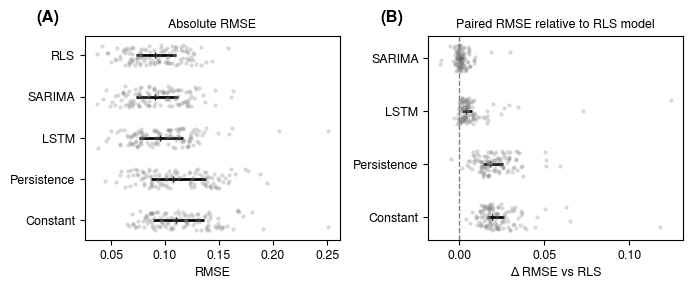

=== Absolute RMSE ===
              median      mean       q25       q75
model_name                                        
rls         0.096739  0.097342  0.077943  0.115781
arima       0.096586  0.097701  0.078379  0.118401
lstm        0.101521  0.103970  0.084694  0.122003
1h lagged   0.118815  0.120714  0.095098  0.139922
mean        0.116408  0.120572  0.100261  0.134774

=== Delta RMSE vs RLS ===
              median      mean       q25       q75
model_name                                        
arima      -0.000197  0.000359 -0.001088  0.001719
lstm        0.004765  0.006628  0.002375  0.007972
1h lagged   0.021867  0.023371  0.016998  0.027509
mean        0.020579  0.023230  0.017001  0.023337


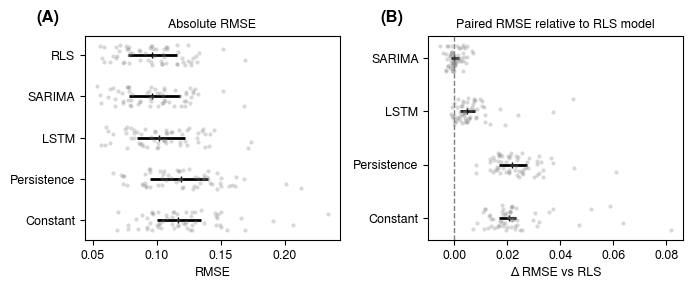

In [14]:
for cohort in ['validation','ctrl']:

    name = 'fig2_model_selection' if cohort == 'validation' else 'figS2_model_selection'
    
    res = load(cohort = cohort)
    stats = plot_model_comparison(
        res=res,
        models_order=order,
        baseline_model='rls',
        model_name_map=model_name_map,
        figname=f'./figs/{name}_{cohort}',
        y=1.13
    )

# Fig 3 and Fig S3: Missingness

## Experiment

mean, median, var, std, q25, q75 [0.092, 0.091, 0.001, 0.025, 0.073, 0.11]
std_err 0.0136
./figs/fig3_missingRLS.jpg


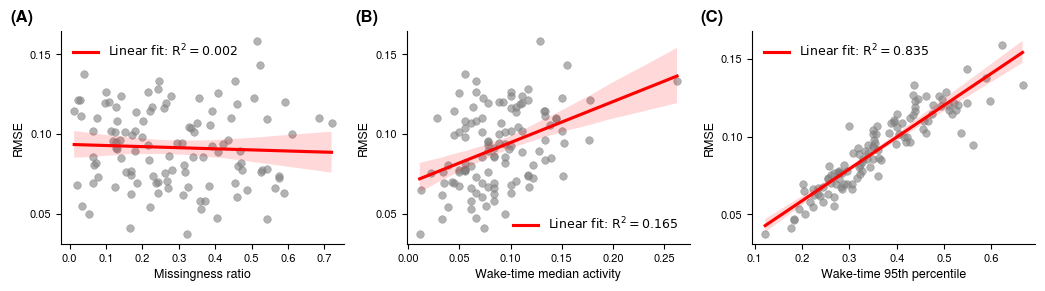

mean, median, var, std, q25, q75 [0.092, 0.091, 0.001, 0.025, 0.073, 0.11]
std_err 0.0136
./figs/fig3_missingrls.jpg


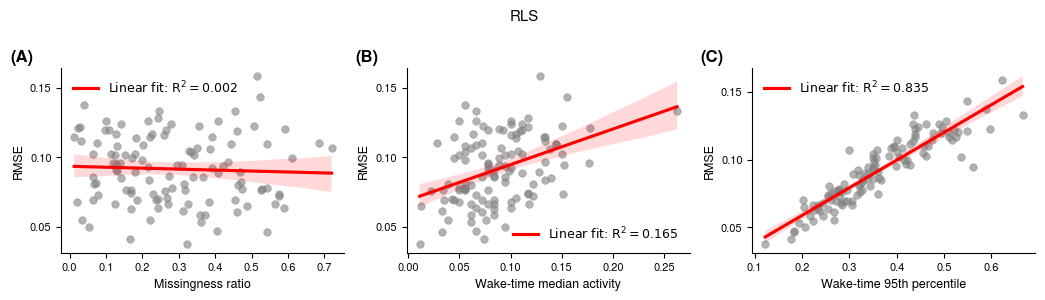

mean, median, var, std, q25, q75 [0.093, 0.09, 0.001, 0.026, 0.073, 0.112]
std_err 0.0143
./figs/fig3_missingarima.jpg


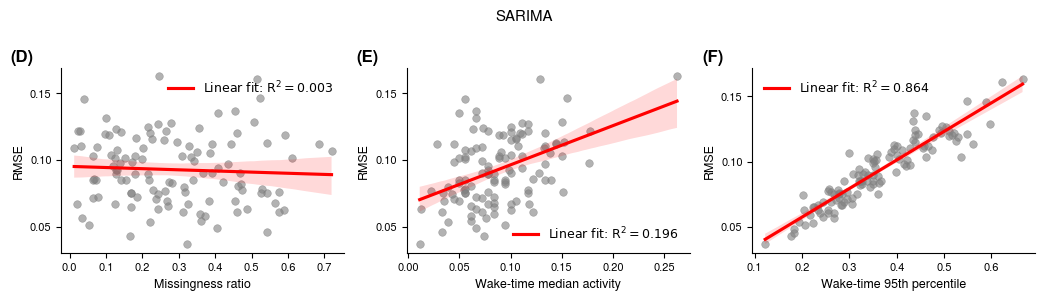

mean, median, var, std, q25, q75 [0.098, 0.095, 0.001, 0.031, 0.076, 0.117]
std_err 0.017
./figs/fig3_missinglstm.jpg


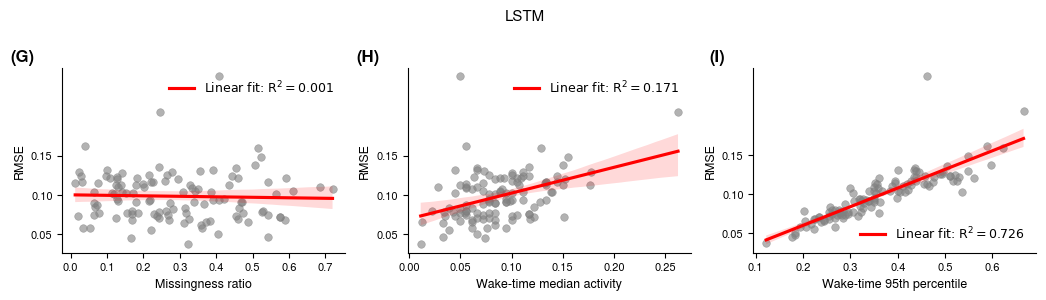

Combined image saved to: ./figs/figS3_combined_missing.jpg


In [33]:
# evaluation cohort
res = load()

# Three panels (missingness + two activity stats)
plot_missingness(res, model_name='rls', activity_stats=['wake_median', 'wake_q95'], title=False, figname='RLS') # RLS

tags = (['A','B','C'],['D','E','F'],['G','H','I'])
for i,model in enumerate(list(model_name_map.keys())[:3]):
    plot_missingness(res, model_name=model, activity_stats=['wake_median', 'wake_q95'], title=True, figname=model, tags=tags[i])

# List your files in the order you want them (Top to Bottom)
files_to_combine = [        
    './figs/fig3_missingrls.jpg',
    './figs/fig3_missingarima.jpg',
    './figs/fig3_missinglstm.jpg'
]

stack_rows_vertical(files_to_combine, './figs/figS3_combined_missing.jpg')

mean, median, var, std, q25, q75 [0.097, 0.097, 0.001, 0.024, 0.078, 0.116]
std_err 0.0216
./figs/fig3_missingrlsctrl.jpg


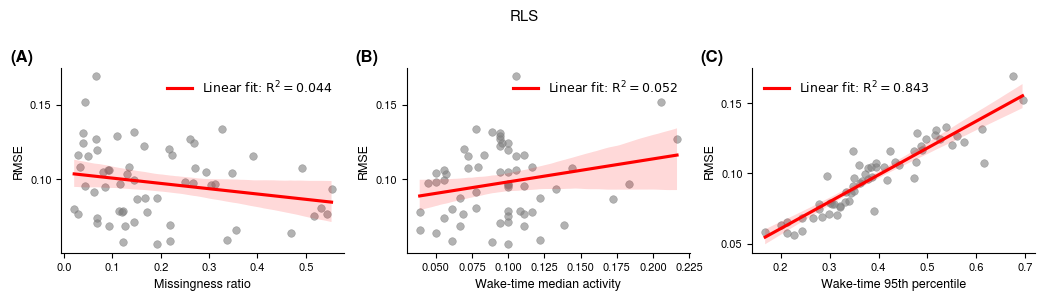

mean, median, var, std, q25, q75 [0.098, 0.097, 0.001, 0.024, 0.078, 0.118]
std_err 0.0216
./figs/fig3_missingarimactrl.jpg


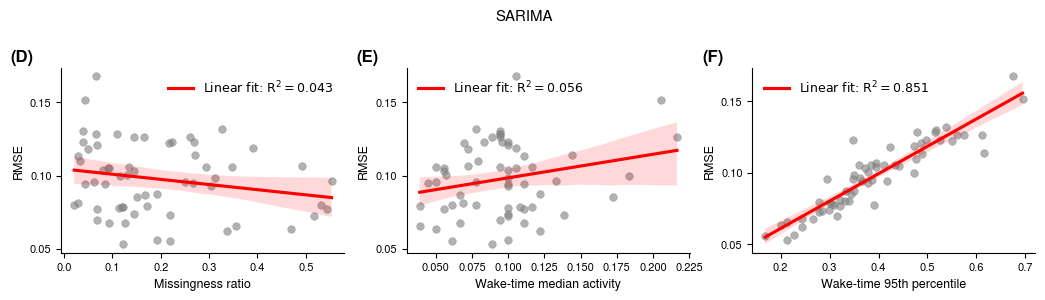

mean, median, var, std, q25, q75 [0.104, 0.102, 0.001, 0.026, 0.085, 0.122]
std_err 0.0232
./figs/fig3_missinglstmctrl.jpg


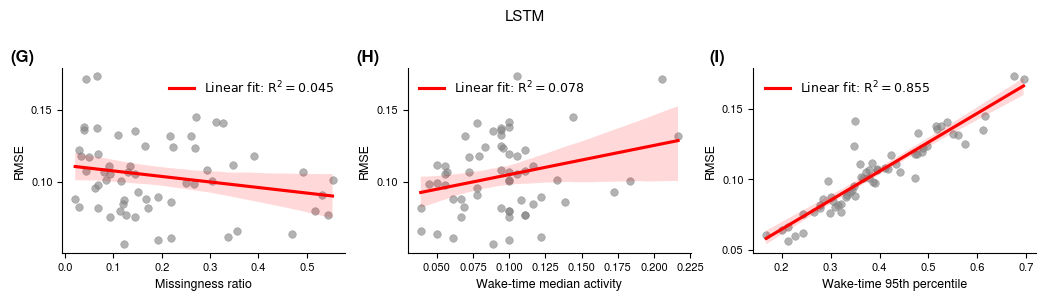

Combined image saved to: ./figs/figS3B_combined_missing_ctrl.jpg


In [34]:
#### Ctrl cohort
res = load(cohort = 'ctrl')
tags = (['A','B','C'],['D','E','F'],['G','H','I'])
for i,model in enumerate(list(model_name_map.keys())[:3]):
    plot_missingness(res, model_name=model, activity_stats=['wake_median', 'wake_q95'], 
                     title=True, figname=model + 'ctrl', tags=tags[i])

# List your files in the order you want them (Top to Bottom)
files_to_combine = [        
    './figs/fig3_missingrlsctrl.jpg',
    './figs/fig3_missingarimactrl.jpg',
    './figs/fig3_missinglstmctrl.jpg'
]

stack_rows_vertical(files_to_combine, './figs/figS3B_combined_missing_ctrl.jpg')

# Fig 4 : Bouts prevented

1. 15min ctrl is missing ARIMA -- but I don't care
2. How to include CTRL?

In [18]:
!ls /sc/arion/projects/Clinical_Times_Series/cpp_data/runs/20251222_1952/predictions/

failed.csv
i0_pvalidation_w15_a_a_marima_h60_burn10.csv
i1_pctrl_w15_a_a_marima_h60_burn10.csv
i2_pvalidation_w15_a_a_mrls_h60_fcross_d0_poly0_logit0_burn10.csv
i3_pctrl_w15_a_a_mrls_h60_fcross_d0_poly0_logit0_burn10.csv
i4_pvalidation_w15_a_a_mlstm_h60_burn10.csv
i5_pctrl_w15_a_a_mlstm_h60_burn10.csv
i6_pvalidation_w15_a_a_mgru_h60_burn10.csv
i7_pctrl_w15_a_a_mgru_h60_burn10.csv



COHORT: VALIDATION
/sc/arion/projects/Clinical_Times_Series/cpp_data/runs/20251222_1952/predictions/i2_pvalidation_w15_a_a_mrls_h60_fcross_d0_poly0_logit0_burn10.csv

----------------------------------------------------------------------
MEAN ANALYSIS (Sensitivity)
----------------------------------------------------------------------

[Analysis 1: 20% Recall Operating Point]

TP_recall:
  sb_def=0.00, i=0 (15min): 0.72
  sb_def=0.03, i=0 (15min): 1.01

FP_recall:
  sb_def=0.00, i=0 (15min): 0.52
  sb_def=0.03, i=0 (15min): 0.42

precision | recall:
  sb_def=0.00, i=0 (15min): 0.59
  sb_def=0.03, i=0 (15min): 0.71


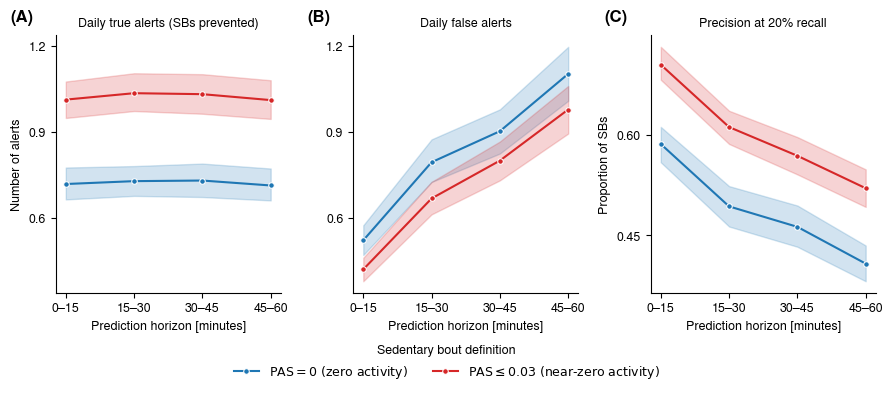


[Analysis 2: F1-Optimized Operating Point]

TP_f1:
  sb_def=0.00, i=0 (15min): 2.76
  sb_def=0.03, i=0 (15min): 4.21

FP_f1:
  sb_def=0.00, i=0 (15min): 3.43
  sb_def=0.03, i=0 (15min): 3.54

precision | f1 max:
  sb_def=0.00, i=0 (15min): 0.43
  sb_def=0.03, i=0 (15min): 0.53


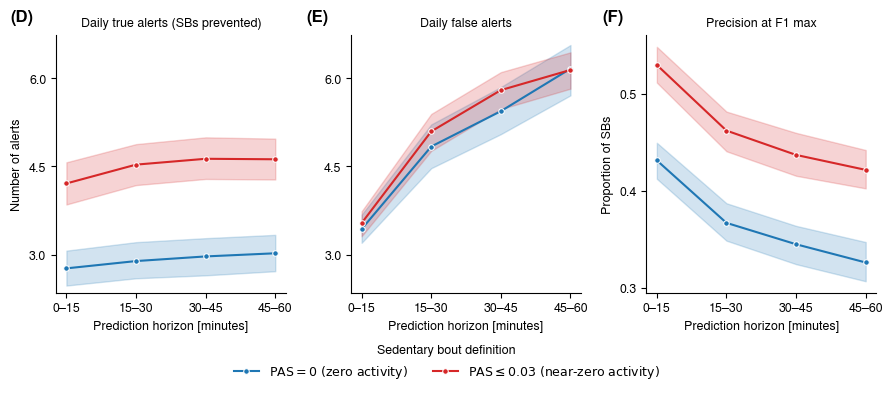


[Analysis 3: F1-Optimized Extended Metrics]

recall | f1 max:
  sb_def=0.00, i=0 (15min): 0.73
  sb_def=0.03, i=0 (15min): 0.80

f1_max:
  sb_def=0.00, i=0 (15min): 0.53
  sb_def=0.03, i=0 (15min): 0.63

balance:
  sb_def=0.00, i=0 (15min): 0.27
  sb_def=0.03, i=0 (15min): 0.38


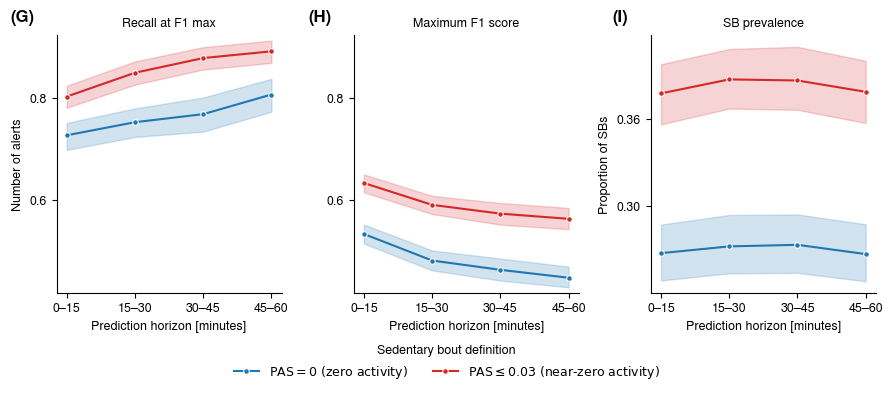

Combined image saved to: ./figs/figS4_sb_validation_mean.jpg

----------------------------------------------------------------------
MEDIAN ANALYSIS (Primary)
----------------------------------------------------------------------

[Analysis 1: 20% Recall Operating Point - MAIN FIGURE]

Results for: ./figs/fig4_ana1_validation_median

TP_recall:
  sb_def=0.00, i=0 (15min): 0.67
  sb_def=0.03, i=0 (15min): 0.99

FP_recall:
  sb_def=0.00, i=0 (15min): 0.49
  sb_def=0.03, i=0 (15min): 0.40

precision | recall:
  sb_def=0.00, i=0 (15min): 0.60
  sb_def=0.03, i=0 (15min): 0.72


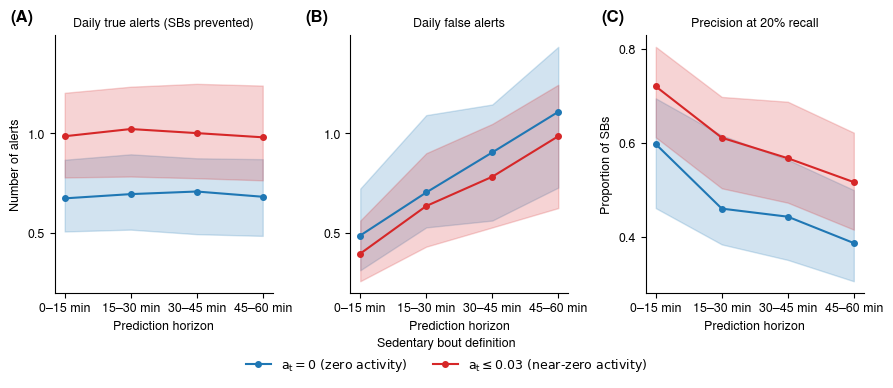


[Analysis 2: F1-Optimized Operating Point - SUPPLEMENT]

Results for: ./figs/suppfig_S4_ana2_validation_median

TP_f1:
  sb_def=0.00, i=0 (15min): 2.49
  sb_def=0.03, i=0 (15min): 3.89

FP_f1:
  sb_def=0.00, i=0 (15min): 3.47
  sb_def=0.03, i=0 (15min): 3.53

precision | f1 max:
  sb_def=0.00, i=0 (15min): 0.43
  sb_def=0.03, i=0 (15min): 0.53


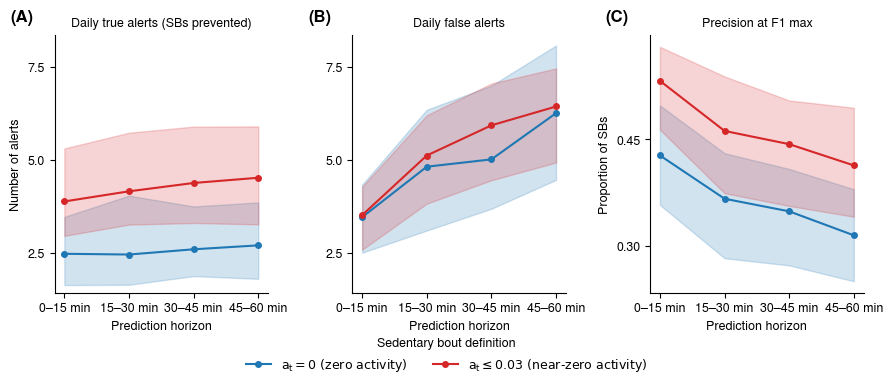


[Analysis 3: F1-Optimized Extended Metrics - SUPPLEMENT]

Results for: ./figs/suppfig_S4_ana3_validation_median

recall | f1 max:
  sb_def=0.00, i=0 (15min): 0.75
  sb_def=0.03, i=0 (15min): 0.82

f1_max:
  sb_def=0.00, i=0 (15min): 0.53
  sb_def=0.03, i=0 (15min): 0.64

balance:
  sb_def=0.00, i=0 (15min): 0.25
  sb_def=0.03, i=0 (15min): 0.36


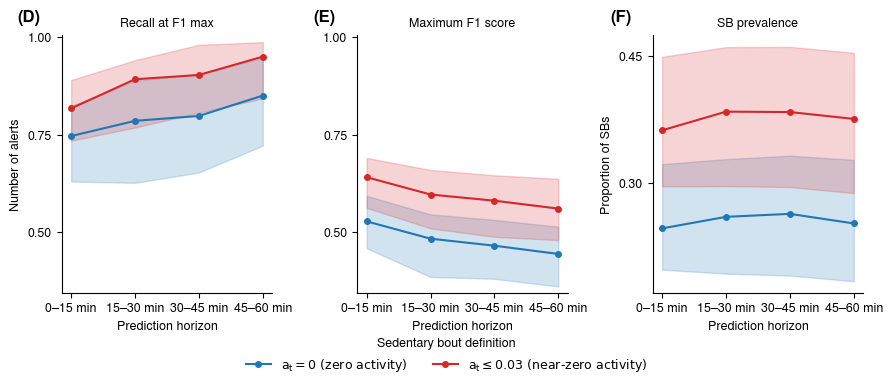

Combined image saved to: ./figs/figS4_sb_validation_median.jpg

COHORT: CTRL
/sc/arion/projects/Clinical_Times_Series/cpp_data/runs/20251222_1952/predictions/i3_pctrl_w15_a_a_mrls_h60_fcross_d0_poly0_logit0_burn10.csv

----------------------------------------------------------------------
MEAN ANALYSIS (Sensitivity)
----------------------------------------------------------------------

[Analysis 1: 20% Recall Operating Point]

TP_recall:
  sb_def=0.00, i=0 (15min): 0.66
  sb_def=0.03, i=0 (15min): 0.94

FP_recall:
  sb_def=0.00, i=0 (15min): 0.48
  sb_def=0.03, i=0 (15min): 0.41

precision | recall:
  sb_def=0.00, i=0 (15min): 0.58
  sb_def=0.03, i=0 (15min): 0.70


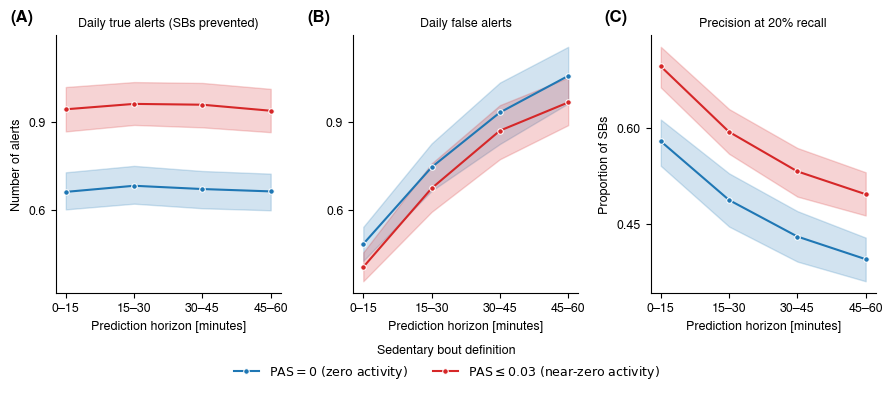


[Analysis 2: F1-Optimized Operating Point]

TP_f1:
  sb_def=0.00, i=0 (15min): 2.50
  sb_def=0.03, i=0 (15min): 3.79

FP_f1:
  sb_def=0.00, i=0 (15min): 3.39
  sb_def=0.03, i=0 (15min): 3.41

precision | f1 max:
  sb_def=0.00, i=0 (15min): 0.41
  sb_def=0.03, i=0 (15min): 0.51


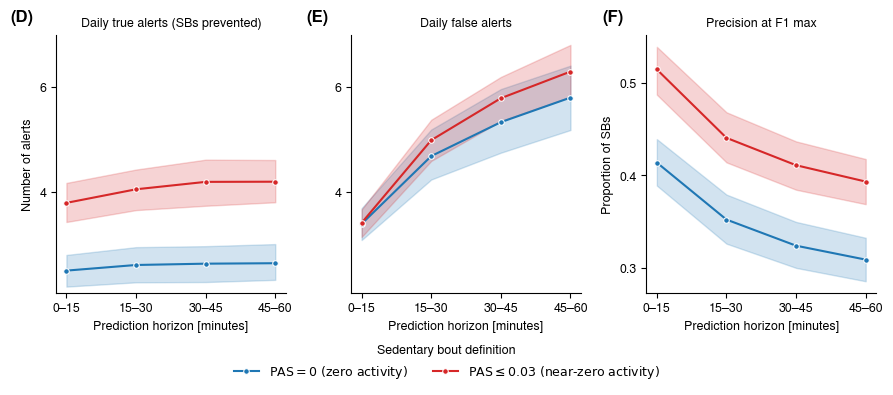


[Analysis 3: F1-Optimized Extended Metrics]

recall | f1 max:
  sb_def=0.00, i=0 (15min): 0.72
  sb_def=0.03, i=0 (15min): 0.78

f1_max:
  sb_def=0.00, i=0 (15min): 0.52
  sb_def=0.03, i=0 (15min): 0.61

balance:
  sb_def=0.00, i=0 (15min): 0.25
  sb_def=0.03, i=0 (15min): 0.35


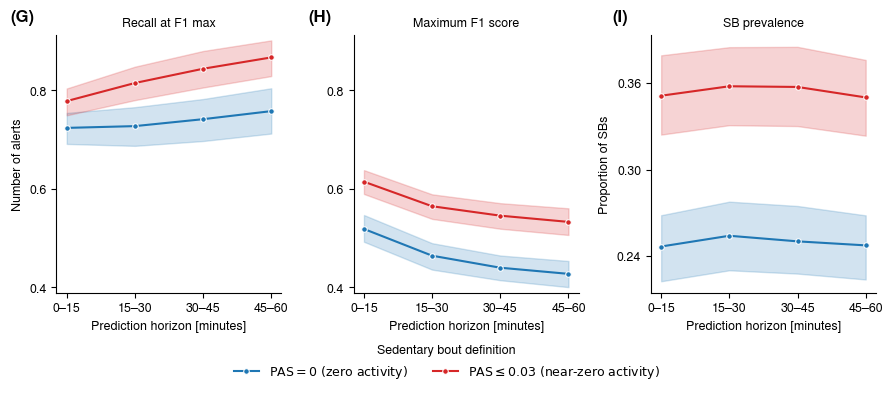

Combined image saved to: ./figs/figS4_sb_ctrl_mean.jpg

----------------------------------------------------------------------
MEDIAN ANALYSIS (Primary)
----------------------------------------------------------------------

[Analysis 1: 20% Recall Operating Point]

Results for: ./figs/fig_S4_ana1_ctrl_median

TP_recall:
  sb_def=0.00, i=0 (15min): 0.61
  sb_def=0.03, i=0 (15min): 0.93

FP_recall:
  sb_def=0.00, i=0 (15min): 0.42
  sb_def=0.03, i=0 (15min): 0.37

precision | recall:
  sb_def=0.00, i=0 (15min): 0.60
  sb_def=0.03, i=0 (15min): 0.71


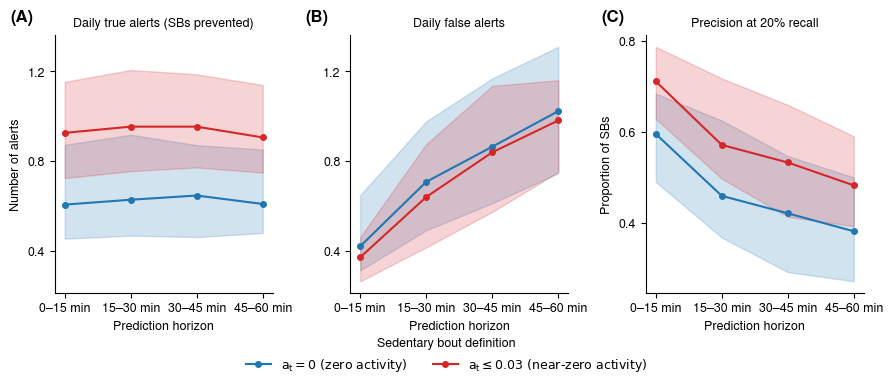


[Analysis 2: F1-Optimized Operating Point]

Results for: ./figs/suppfig_S4_ana2_ctrl_median

TP_f1:
  sb_def=0.00, i=0 (15min): 2.19
  sb_def=0.03, i=0 (15min): 3.68

FP_f1:
  sb_def=0.00, i=0 (15min): 3.51
  sb_def=0.03, i=0 (15min): 3.40

precision | f1 max:
  sb_def=0.00, i=0 (15min): 0.42
  sb_def=0.03, i=0 (15min): 0.52


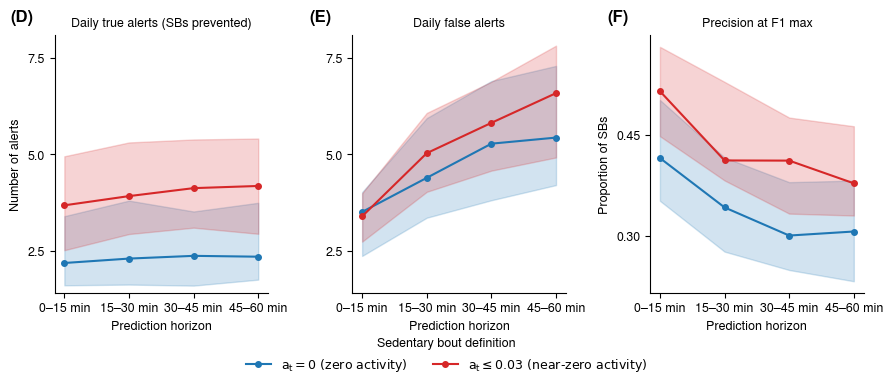


[Analysis 3: F1-Optimized Extended Metrics]

Results for: ./figs/suppfig_S4_ana3_ctrl_median

recall | f1 max:
  sb_def=0.00, i=0 (15min): 0.74
  sb_def=0.03, i=0 (15min): 0.79

f1_max:
  sb_def=0.00, i=0 (15min): 0.51
  sb_def=0.03, i=0 (15min): 0.62

balance:
  sb_def=0.00, i=0 (15min): 0.22
  sb_def=0.03, i=0 (15min): 0.34


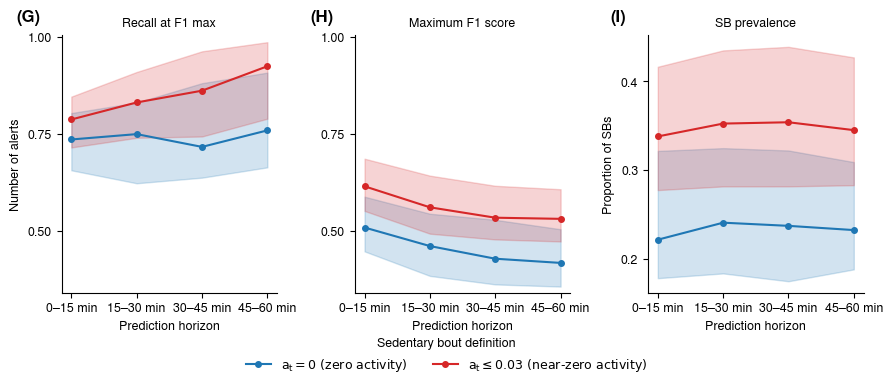

Combined image saved to: ./figs/figS4_sb_ctrl_median.jpg

ALL ANALYSES COMPLETE


In [19]:
# Shared configurations to reduce clutter
metrics_recall = ['TP_recall', 'FP_recall', 'precision | recall']
titles_recall  = ['Daily true alerts (SBs prevented)', 'Daily false alerts', 'Precision at 20% recall']
metrics_f1_opt = ['TP_f1', 'FP_f1', 'precision | f1 max']
titles_f1_opt  = ['Daily true alerts (SBs prevented)', 'Daily false alerts', 'Precision at F1 max']
metrics_f1_ext = ['recall | f1 max', 'f1_max', 'balance']
titles_f1_ext  = ['Recall at F1 max', 'Maximum F1 score', 'SB prevalence']

for cohort in ['validation', 'ctrl']:
    print("\n" + "="*70)
    print(f"COHORT: {cohort.upper()}")
    print("="*70)
    
    res = load2(cohort=cohort, window=15)
    
    # ------------------------------------------------------------------
    # 1. MEAN ANALYSIS (Sensitivity)
    # ------------------------------------------------------------------
    print("\n" + "-"*70)
    print("MEAN ANALYSIS (Sensitivity)")
    print("-"*70)
    
    suff = f'{cohort}_mean'
    path_mean_recall = f'./figs/suppfig_S4_ana1_{suff}'
    path_mean_f1_opt = f'./figs/suppfig_S4_ana2_{suff}'
    path_mean_f1_ext = f'./figs/suppfig_S4_ana3_{suff}'
    
    print("\n[Analysis 1: 20% Recall Operating Point]")
    plot_prevented15(res, metrics=metrics_recall, titles=titles_recall, tags=['A','B','C'], figname=path_mean_recall)
    
    print("\n[Analysis 2: F1-Optimized Operating Point]")
    plot_prevented15(res, metrics=metrics_f1_opt, titles=titles_f1_opt, tags=['D','E','F'], figname=path_mean_f1_opt)
    
    print("\n[Analysis 3: F1-Optimized Extended Metrics]")
    plot_prevented15(res, metrics=metrics_f1_ext, titles=titles_f1_ext, tags=['G','H','I'], figname=path_mean_f1_ext)
    
    stack_rows_vertical([f'{path_mean_recall}.jpg', f'{path_mean_f1_opt}.jpg', f'{path_mean_f1_ext}.jpg'], 
                        f'./figs/figS4_sb_{suff}.jpg')
    
    # ------------------------------------------------------------------
    # 2. MEDIAN ANALYSIS (Primary)
    # ------------------------------------------------------------------
    print("\n" + "-"*70)
    print("MEDIAN ANALYSIS (Primary)")
    print("-"*70)
    
    suff = f'{cohort}_median'
    
    if cohort == 'ctrl':        
        path_med_recall = f'./figs/suppfig_S4_ana1_{suff}'
        path_med_f1_opt = f'./figs/suppfig_S4_ana2_{suff}'
        path_med_f1_ext = f'./figs/suppfig_S4_ana3_{suff}'
        
        print("\n[Analysis 1: 20% Recall Operating Point]")
        sb_prevented_median(res, metrics=metrics_recall, titles=titles_recall, tags=['A','B','C'], figname=path_med_recall)
        
        print("\n[Analysis 2: F1-Optimized Operating Point]")
        sb_prevented_median(res, metrics=metrics_f1_opt, titles=titles_f1_opt, tags=['D','E','F'], figname=path_med_f1_opt)
        
        print("\n[Analysis 3: F1-Optimized Extended Metrics]")
        sb_prevented_median(res, metrics=metrics_f1_ext, titles=titles_f1_ext, tags=['G','H','I'], figname=path_med_f1_ext)
        
        stack_rows_vertical([f'{path_med_recall}.jpg', f'{path_med_f1_opt}.jpg', f'{path_med_f1_ext}.jpg'], 
                            f'./figs/figS4_sb_{suff}.jpg')
    
    else:  # validation cohort        
        path_med_recall = f'./figs/fig4_ana1_{suff}'
        path_med_f1_opt = f'./figs/suppfig_S4_ana2_{suff}'
        path_med_f1_ext = f'./figs/suppfig_S4_ana3_{suff}'
        
        print("\n[Analysis 1: 20% Recall Operating Point - MAIN FIGURE]")
        sb_prevented_median(res, metrics=metrics_recall, titles=titles_recall, tags=['A','B','C'], figname=path_med_recall)
        
        print("\n[Analysis 2: F1-Optimized Operating Point - SUPPLEMENT]")
        sb_prevented_median(res, metrics=metrics_f1_opt, titles=titles_f1_opt, tags=['A','B','C'], figname=path_med_f1_opt)
        
        print("\n[Analysis 3: F1-Optimized Extended Metrics - SUPPLEMENT]")
        sb_prevented_median(res, metrics=metrics_f1_ext, titles=titles_f1_ext, tags=['D','E','F'], figname=path_med_f1_ext)
        
        # Stacking only the supplemental rows for the appendix
        stack_rows_vertical([f'{path_med_f1_opt}.jpg', f'{path_med_f1_ext}.jpg'], 
                            f'./figs/figS4_sb_{suff}.jpg')

print("\n" + "="*70)
print("ALL ANALYSES COMPLETE")
print("="*70)

### SBs at 60 min 

In [20]:
res = load2(window=60, cohort='ctrl')

/sc/arion/projects/Clinical_Times_Series/cpp_data/runs/20251222_1325/predictions/i3_pctrl_w60_a_a_mrls_h60_fcross_d0_poly0_logit0_burn10.csv


In [21]:
res.groupby('sb_def').mean().T.round(2)

sb_def,0.00,0.03
precision | recall,0.39,0.57
precision | f1 max,0.28,0.38
recall | f1 max,0.45,0.63
f1_max,0.30,0.46
average_PR,0.21,0.41
balance,0.06,0.21
TP_recall,0.15,0.54
FP_recall,0.43,0.46
TP_f1,0.41,1.82
FP_f1,1.37,2.87


In [22]:
res.groupby('sb_def').median().T.round(2)

sb_def,0.00,0.03
precision | recall,0.32,0.57
precision | f1 max,0.24,0.38
recall | f1 max,0.43,0.62
f1_max,0.28,0.45
average_PR,0.17,0.40
balance,0.04,0.18
TP_recall,0.10,0.46
FP_recall,0.32,0.36
TP_f1,0.18,1.42
FP_f1,0.81,2.88


### Median activity

##### Funct

In [23]:
def collect_participant_statistics(archive, case=True):
    """
    Collect comprehensive participant-level statistics from archive.
    
    Parameters:
    -----------
    archive : dict
        Archive with 'data' and 'metadata' keys
        
    Returns:
    --------
    DataFrame with participant-level statistics and quality flags
    
    Notes:
    ------
    - All np.nan* functions (nanmean, nanmedian, etc.) automatically exclude NaN values
    - "wake_*" statistics are computed only on wake-time data (sleep=0, activity non-NaN)
    - "all_*" statistics are computed on all time periods (activity non-NaN, regardless of sleep)
    """
    stats_list = []
    
    for dat, meta in zip(archive['data'], archive['metadata']):
        # Extract activity and sleep data
        activity = dat[:, :, 0]
        sleep = np.round(dat[:, :, 2])
        
        # Flatten for statistics
        activity_flat = activity.flatten()
        sleep_flat = sleep.flatten()
        
        # Create wake mask (sleep=0 AND activity is not NaN)
        wake_mask = (sleep_flat == 0) & (~np.isnan(activity_flat))
        activity_wake = activity_flat[wake_mask]
        
        # Wake-time statistics (only during wake periods with valid activity)

        if len(activity_wake) > 0:
            wake_mean = np.mean(activity_wake)
            wake_median = np.median(activity_wake)
            wake_std = np.std(activity_wake)
            wake_q25 = np.quantile(activity_wake, 0.25)
            wake_q75 = np.quantile(activity_wake, 0.75)
            wake_iqr = wake_q75 - wake_q25
            wake_q95 = np.quantile(activity_wake, 0.95)
        else:
            # No valid wake-time data
            wake_mean = np.nan
            wake_median = np.nan
            wake_std = np.nan
            wake_q25 = np.nan
            wake_q75 = np.nan
            wake_iqr = np.nan
            wake_q95 = np.nan
                
        # All-time statistics (wake + sleep, but excluding NaN)
        all_mean = np.nanmean(activity_flat)  # nanmean divides by N_valid
        all_median = np.nanmedian(activity_flat)
        all_std = np.nanstd(activity_flat)  # nanstd uses N_valid for denominator
        all_q25 = np.nanquantile(activity_flat, 0.25)
        all_q75 = np.nanquantile(activity_flat, 0.75)
        all_iqr = all_q75 - all_q25
        all_q95 = np.nanquantile(activity_flat, 0.95)
        
        # Missingness statistics (across all time periods)
        nans = np.isnan(activity_flat)
        nan_count = nans.sum()
        total_count = len(activity_flat)
        nonmissing_count = total_count - nan_count
        missingness_ratio = nans.mean()  # mean of boolean = proportion
        
        # Quality flags
        flag_high_quality = missingness_ratio < 0.10  # >90% non-missing
        flag_sufficient_data = nonmissing_count >= 480  # At least 480 hours
        
        # Participant ID
        pid = meta['patient_id']
        
        # Compile statistics
        stats_list.append({
            'pid': pid,
            # Wake-time statistics
            'wake_mean': wake_mean,
            'wake_median': wake_median,
            'wake_std': wake_std,
            'wake_q25': wake_q25,
            'wake_q75': wake_q75,
            'wake_iqr': wake_iqr,
            'wake_q95': wake_q95,
            # All-time statistics
            'all_mean': all_mean,
            'all_median': all_median,
            'all_std': all_std,
            'all_q25': all_q25,
            'all_q75': all_q75,
            'all_iqr': all_iqr,
            'all_q95': all_q95,
            # Missingness metrics
            'total_hours': total_count,
            'nonmissing_hours': nonmissing_count,
            'missing_hours': nan_count,
            'missingness_ratio': missingness_ratio,
            # Quality flags
            'flag_high_quality': flag_high_quality,
            'flag_sufficient_data': flag_sufficient_data
        })
        
        # Cohort definitions
        if case:
            stats_list[-1]['Tuning'] = flag_high_quality
            stats_list[-1]['Evaluation'] = flag_sufficient_data and (flag_high_quality == False)
            stats_list[-1]['Controls'] = False
        else: # ctrl
            stats_list[-1]['Controls'] = flag_high_quality
            stats_list[-1]['Tuning'] = False
            stats_list[-1]['Evaluation'] = False
            
    return pd.DataFrame(stats_list)

In [24]:
path_case = '/sc/arion/projects/Clinical_Times_Series/cpp_data/final/processed/case/revision_nan_all_patients_60.npz'
path_ctrl = '/sc/arion/projects/Clinical_Times_Series/cpp_data/final/processed/ctrl/revision_nan_all_patients_60.npz'

dfs = []
for (is_case, path) in zip([True, False],[path_case,path_ctrl]):

    archive = np.load(path, allow_pickle=True)
    dfs.append(collect_participant_statistics(archive, is_case))

df = pd.concat(dfs)

In [25]:
df.to_csv('PAS_stats_window_60min.csv')

# Fig 5: PAS errors VS SB-precision

/sc/arion/projects/Clinical_Times_Series/cpp_data/runs/20251222_1952/predictions/i2_pvalidation_w15_a_a_mrls_h60_fcross_d0_poly0_logit0_burn10.csv


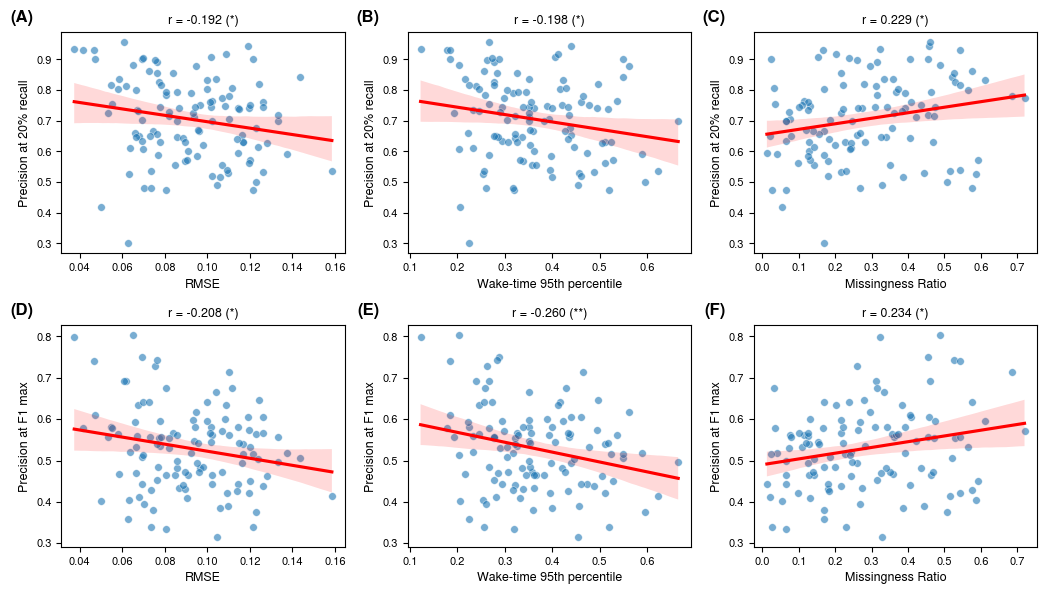


Correlation Statistics:

precision | recall:
  vs rmse: r = -0.1922, p = 0.0396, n = 115
  vs wake_q95: r = -0.1978, p = 0.0341, n = 115
  vs missingness_ratio: r = 0.2294, p = 0.0137, n = 115

precision | f1 max:
  vs rmse: r = -0.2084, p = 0.0254, n = 115
  vs wake_q95: r = -0.2603, p = 0.0050, n = 115
  vs missingness_ratio: r = 0.2343, p = 0.0117, n = 115


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import numpy as np

# Load and merge data
cohort = 'validation'
burn_in = 10
recall_fixed = 0.2
tol = 0.05

df_60min = load(cohort=cohort, burn_in=burn_in, window=60)
df_60min = df_60min[df_60min.model_name == 'rls']

df_15min = load2(cohort=cohort, burn_in=burn_in, window=15, 
                 recall_fixed=recall_fixed, tol=tol)

df = df_15min.merge(df_60min, on='pid', how='inner', suffixes=('_15min', '_60min'))

# Add missingness ratio
df['missingness_ratio'] = df['nan_days'] / df['total_days']

# Filter data
pred_horizon = 0  # or 1, 2, 3
thres = 0.03  # or 0
df_plot = df[(df.i == pred_horizon) & (df.sb_def == thres)]

# Create visualizations - Nature dimensions: each pane (3.5, 3) inches
# 2x3 grid = (10.5, 6) inches
fig, axes = plt.subplots(2, 3, figsize=(10.5, 6))

x_cols = ['rmse', 'wake_q95', 'missingness_ratio']
y_cols = ['precision | recall', 'precision | f1 max']

tags = np.array([['A','D'],['B','E'],['C','F']]).T

for row_idx, y_col in enumerate(y_cols):
    for col_idx, x_col in enumerate(x_cols):
        ax = axes[row_idx, col_idx]

        add_lab(ax,tags[row_idx,col_idx], y=1.1)
        
        # Remove rows with NaN values for this pair
        df_clean = df_plot[[x_col, y_col]].dropna()
        
        if len(df_clean) > 2:  # Need at least 3 points for correlation
            # Calculate correlation
            r, p = pearsonr(df_clean[x_col], df_clean[y_col])
            
            # Scatter plot
            sns.scatterplot(data=df_clean, x=x_col, y=y_col, 
                          alpha=0.6, ax=ax, s=30)
            
            # Add regression line
            sns.regplot(data=df_clean, x=x_col, y=y_col, 
                       scatter=False, color='red', ax=ax, ci=95)
            
            # Set labels
            if x_col == 'rmse':
                x_label = 'RMSE'
            elif x_col == 'wake_q95':
                x_label = 'Wake-time 95th percentile'
            else:  # missingness_ratio
                x_label = 'Missingness Ratio'
            
            y_label = 'Precision at 20% recall' if 'recall' in y_col else 'Precision at F1 max'
            
            ax.set_xlabel(x_label, fontsize=9)
            ax.set_ylabel(y_label, fontsize=9)
            
            # Title with correlation and p-value
            sig_str = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'
            ax.set_title(f'r = {r:.3f} ({sig_str})', fontsize=9)
            
            # Tick label size
            ax.tick_params(labelsize=8)
        else:
            ax.text(0.5, 0.5, 'Insufficient data', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_xlabel(x_col, fontsize=9)
            ax.set_ylabel(y_col, fontsize=9)

plt.tight_layout()
plt.savefig('./figs/activity_q95_vs_sb_precision.jpg', dpi=300, bbox_inches='tight')
plt.show()

# Print correlation statistics
print("\nCorrelation Statistics:")
print("=" * 60)
for y_col in y_cols:
    print(f"\n{y_col}:")
    for x_col in x_cols:
        df_clean = df_plot[[x_col, y_col]].dropna()
        if len(df_clean) > 2:
            r, p = pearsonr(df_clean[x_col], df_clean[y_col])
            print(f"  vs {x_col}: r = {r:.4f}, p = {p:.4f}, n = {len(df_clean)}")
        else:
            print(f"  vs {x_col}: insufficient data (n = {len(df_clean)})")

# Supp Figure Data sensitivity

In [ ]:
df0 = load_dt()

PLOT 2: Data Completeness vs Threshold (60 min window)

Threshold = 0.2:
  Mean ± SEM: 0.5689 ± 0.0219
  Median (IQR): 0.5906 (0.4068 - 0.7919), IQR width = 0.3851

Threshold = 0.3:
  Mean ± SEM: 0.5658 ± 0.0219
  Median (IQR): 0.5889 (0.4026 - 0.7903), IQR width = 0.3876

Threshold = 0.4:
  Mean ± SEM: 0.5625 ± 0.0218
  Median (IQR): 0.5859 (0.4007 - 0.7861), IQR width = 0.3854

Threshold = 0.6:
  Mean ± SEM: 0.5541 ± 0.0216
  Median (IQR): 0.5794 (0.3943 - 0.7773), IQR width = 0.3830

Threshold = 0.8:
  Mean ± SEM: 0.5413 ± 0.0212
  Median (IQR): 0.5625 (0.3828 - 0.7740), IQR width = 0.3912

Threshold = 1.0:
  Mean ± SEM: 0.5064 ± 0.0201
  Median (IQR): 0.5248 (0.3417 - 0.7079), IQR width = 0.3662

PLOT 3: Data Completeness - 15 vs 60 min (threshold = 0.3)

15 min:
  Mean ± SEM: 0.5585 ± 0.0217
  Median (IQR): 0.5816 (0.3975 - 0.7823), IQR width = 0.3848

60 min:
  Mean ± SEM: 0.5658 ± 0.0219
  Median (IQR): 0.5889 (0.4026 - 0.7903), IQR width = 0.3876

Figure saved to ./figs/data_co

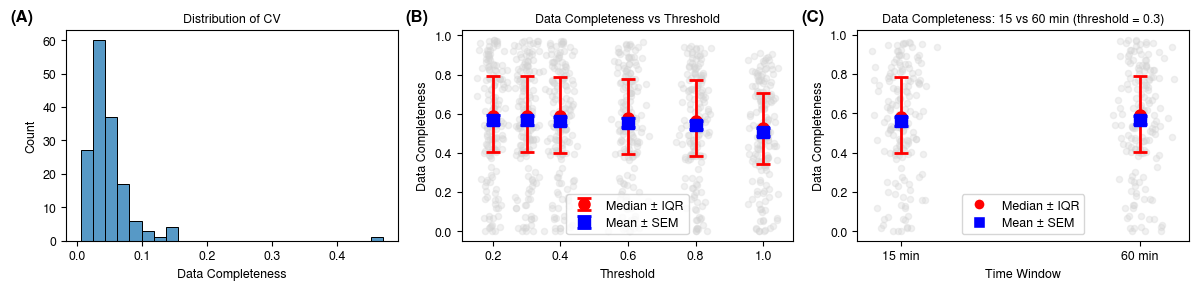

In [5]:
import os

df = df0[df0.w == 60]
summary = df.groupby('pid').std()/df.groupby('pid').mean()

# Create figure with 3 subplots
f, axs = plt.subplots(1, 3, figsize=[12, 3])

# Plot 1: Histogram (unchanged)
sns.histplot(summary, x='c', ax=axs[0])
axs[0].set_title('Distribution of CV')
axs[0].set_xlabel('Data Completeness')

# Plot 2: Unified scatter plot with both mean and median
# Create jittered scatter plot
x_jitter = df['thres'] + np.random.normal(0, 0.02, size=len(df))
axs[1].scatter(x_jitter, df['c'], alpha=0.3, s=20, color='lightgray')

# Calculate statistics
medians = df.groupby('thres')['c'].median()
q1 = df.groupby('thres')['c'].quantile(0.25)
q3 = df.groupby('thres')['c'].quantile(0.75)
means = df.groupby('thres')['c'].mean()
std_errs = df.groupby('thres')['c'].sem()
x_pos = medians.index

# Print metrics for Plot 2 (Threshold comparison)
print("=" * 60)
print("PLOT 2: Data Completeness vs Threshold (60 min window)")
print("=" * 60)
for thresh in x_pos:
    iqr = q3[thresh] - q1[thresh]
    print(f"\nThreshold = {thresh}:")
    print(f"  Mean ± SEM: {means[thresh]:.4f} ± {std_errs[thresh]:.4f}")
    print(f"  Median (IQR): {medians[thresh]:.4f} ({q1[thresh]:.4f} - {q3[thresh]:.4f}), IQR width = {iqr:.4f}")

# Overlay median with IQR
axs[1].errorbar(x_pos, medians, 
                yerr=[medians - q1, q3 - medians],
                fmt='o', color='red', markersize=8, 
                linewidth=2, capsize=5, capthick=2,
                label='Median ± IQR')

# Overlay mean with SEM
axs[1].errorbar(x_pos, means, 
                yerr=std_errs,
                fmt='s', color='blue', markersize=8, 
                linewidth=2, capsize=5, capthick=2,
                label='Mean ± SEM')

axs[1].set_xlabel('Threshold')
axs[1].set_ylabel('Data Completeness')
axs[1].set_title('Data Completeness vs Threshold')
axs[1].legend()

# Plot 3: Compare 15 vs 60 min time steps at 0.3 threshold
df_15 = df0[(df0['thres'] == 0.3) & (df0['w'] == 15)]
df_60 = df0[(df0['thres'] == 0.3) & (df0['w'] == 60)]

# Combine for plotting
df_comp = pd.concat([df_15.assign(window='15 min'), 
                     df_60.assign(window='60 min')])

# Create jittered scatter plot
windows = ['15 min', '60 min']
x_map = {w: i for i, w in enumerate(windows)}
x_jitter_comp = df_comp['window'].map(x_map) + np.random.normal(0, 0.05, size=len(df_comp))
axs[2].scatter(x_jitter_comp, df_comp['c'], alpha=0.3, s=20, color='lightgray')

# Print metrics for Plot 3 (Window comparison)
print("\n" + "=" * 60)
print("PLOT 3: Data Completeness - 15 vs 60 min (threshold = 0.3)")
print("=" * 60)

# Calculate statistics for each window
for i, window in enumerate(windows):
    df_w = df_comp[df_comp['window'] == window]
    
    median = df_w['c'].median()
    q1 = df_w['c'].quantile(0.25)
    q3 = df_w['c'].quantile(0.75)
    mean = df_w['c'].mean()
    sem = df_w['c'].sem()
    iqr = q3 - q1
    
    # Print metrics
    print(f"\n{window}:")
    print(f"  Mean ± SEM: {mean:.4f} ± {sem:.4f}")
    print(f"  Median (IQR): {median:.4f} ({q1:.4f} - {q3:.4f}), IQR width = {iqr:.4f}")
    
    # Median with IQR
    axs[2].errorbar(i, median, 
                    yerr=[[median - q1], [q3 - median]],
                    fmt='o', color='red', markersize=8, 
                    linewidth=2, capsize=5, capthick=2)
    
    # Mean with SEM
    axs[2].errorbar(i, mean, 
                    yerr=sem,
                    fmt='s', color='blue', markersize=8, 
                    linewidth=2, capsize=5, capthick=2)

print("=" * 60)

axs[2].set_xticks([0, 1])
axs[2].set_xticklabels(windows)
axs[2].set_xlabel('Time Window')
axs[2].set_ylabel('Data Completeness')
axs[2].set_title('Data Completeness: 15 vs 60 min (threshold = 0.3)')

# Add legend manually (only once)
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', 
                          markerfacecolor='red', markersize=8, label='Median ± IQR'),
                   Line2D([0], [0], marker='s', color='w', 
                          markerfacecolor='blue', markersize=8, label='Mean ± SEM')]
axs[2].legend(handles=legend_elements)

tags = ['A','B','C']
for i,tag in enumerate(tags):
    add_lab(axs[i], tag, y=1.1)

plt.tight_layout()

# Save figure
os.makedirs('./figs', exist_ok=True)
plt.savefig('./figs/data_completeness_analysis.jpg', dpi=300, bbox_inches='tight')
plt.savefig('./figs/data_completeness_analysis.pdf', bbox_inches='tight')
print(f"\nFigure saved to ./figs/data_completeness_analysis.jpg and .pdf")